# Importando

In [204]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import re
import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Leitura dos arquivos de dados usando o Pandas

In [205]:
mlb_df=pd.read_csv("assets/mlb.csv")
nhl_df=pd.read_csv("assets/nhl.csv")
nba_df=pd.read_csv("assets/nba.csv")
nfl_df=pd.read_csv("assets/nfl.csv")
cities=pd.read_html("assets/wikipedia_data.html")[1]
cities=cities.iloc[:-1,[0,3,5,6,7,8]]

In [193]:
cities.head()

,Metropolitan area,Population (2016 est.)[8],NFL,MLB,NBA,NHL
0,New York City,20153634,GiantsJets[note 1],YankeesMets[note 2],KnicksNets,RangersIslandersDevils[note 3]
1,Los Angeles,13310447,RamsChargers[note 4],DodgersAngels,LakersClippers,KingsDucks
2,San Francisco Bay Area,6657982,49ersRaiders[note 6],GiantsAthletics,Warriors,Sharks[note 7]
3,Chicago,9512999,Bears[note 8],CubsWhite Sox,Bulls[note 9],Blackhawks
4,Dallas–Fort Worth,7233323,Cowboys,Rangers,Mavericks,Stars


In [6]:
nhl_df.head()

,team,GP,W,L,OL,PTS,PTS%,GF,GA,SRS,SOS,RPt%,ROW,year,League
0,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,2018,NHL
1,Tampa Bay Lightning*,82,54,23,5,113,.689,296,236,0.66,-0.07,.634,48,2018,NHL
2,Boston Bruins*,82,50,20,12,112,.683,270,214,0.62,-0.07,.610,47,2018,NHL
3,Toronto Maple Leafs*,82,49,26,7,105,.640,277,232,0.49,-0.06,.567,42,2018,NHL
4,Florida Panthers,82,44,30,8,96,.585,248,246,-0.01,-0.04,.537,41,2018,NHL


Podemos ver acima que os dados precisam de um tratamento prévio. Dentro de cada campeonato os nomes dos times 
não estão separados corretamente, apesar de cada nome sempre começar com uma letra maiúscula. 
Além disso vemos a presença de chaves com informações unúteis em várias entradas.
Cada time deve ser conectado pelo seu nome com os dados presentes nos dados individuais de cada liga.

# Tratamento

Vamos começar com os dados contidos em cities, já que essa base será usada em conjunto com todas as outras.

Começamos removendo os '*' que aparecem no final dos nomes de alguns times.

In [206]:
cities['NHL'] = cities['NHL'].str.replace(r"\[.*\]","", regex=True) 
cities['NBA'] = cities['NBA'].str.replace(r"\[.*\]","", regex=True) 
cities['MLB'] = cities['MLB'].str.replace(r"\[.*\]","", regex=True) 
cities['NFL'] = cities['NFL'].str.replace(r"\[.*\]","", regex=True) 

Em seguida separamos os nomes dos times em cada liga, usando as letras maiúsculas como um identificador.
Ou seja, inserimos espaços antes de cada letra maiúscula.

In [207]:
# função que insere um espaço antes de cada letra maiúscula em uma string.
def cap_space(text):
    new_text = ' '
    for i, letter in enumerate(text):
        if i != 0 and letter.isupper():
            new_text +=' '
        new_text += letter
    return new_text

In [208]:
# NHL
# Insere espaços entro os nomes dos times em cada entrada.
for i in range(len(cities['NHL'])):
    cities['NHL'][i] = cap_space(cities['NHL'][i])

# Deleta espaços extras, antes e depois do nome e insere NaN's nas células sem nada ou com '—'.
cities['NHL'] = cities['NHL'].str.strip().replace(['','—'],np.nan)

#NBA
for i in range(len(cities['NBA'])):
    cities['NBA'][i] = cap_space(cities['NBA'][i])
    
cities['NBA'] = cities['NBA'].str.strip()
cities['NBA'] = cities['NBA'].replace(['','—'],np.nan)

#MLB
for i in range(len(cities['MLB'])):
    cities['MLB'][i] = cap_space(cities['MLB'][i])

cities['MLB'] = cities['MLB'].str.strip()
cities['MLB'] = cities['MLB'].replace(['','—'],np.nan)

#NFL
for i in range(len(cities['NFL'])):
    cities['NFL'][i] = cap_space(cities['NFL'][i])

cities['NFL'] = cities['NFL'].str.strip()
cities['NFL'] = cities['NFL'].replace(['','—'],np.nan)

Por fim vamos calcular as correlações entre a taxa de vitórias em relação às derrotas (W / (W + L)) e a população em cada região metropolitana.

In [209]:
def corr_nhl(cities, nhl_df):
    
    # seleciona apenas as linhas sem NaN na coluna NHL
    cities = cities[cities['NHL'].notna()]
    
    # separa os nomes na coluna NHL colocando cada nome em uma coluna diferente.
    # dessa forma podemos comparar nome a nome com o dataframe cities.
    cities[['name1','name2','name3']] = cities['NHL'].str.split(expand=True)
    
    nhl_df = nhl_df[['team', 'W', 'L', 'year']]
    
    # retira os '*' do dataframe nhl_df
    nhl_df['team'] = nhl_df['team'].str.replace(r'[\*]','')
    # separa os nomes nesse dataframe também
    nhl_df[['name1','name2','name3']] = nhl_df['team'].str.split(expand=True)
    #seleciona apenas o ano de 2018
    nhl_df = nhl_df[nhl_df['year']>=2018]
    
    # loop que compara todas as combinações de nomes e usa o merge nos dois dataframes para cada combinação.
    # depois todos os dataframes gerados são concatenados em um só.
    names=['name1','name2','name3']
    frames = []
    for i in names:
        for j in names:
            temp_pd = pd.merge(nhl_df, cities[cities[i].notna()], how='inner', left_on=[j],right_on=[i])
            frames.append(temp_pd)
    merged_nhl = pd.concat(frames)
    
    # Na coluna 'team' aparecem alguns times duplicados que devem ser descartados.
    merged_nhl = merged_nhl.drop_duplicates(subset="team")
    merged_nhl = merged_nhl[['team','NHL','Metropolitan area','Population (2016 est.)[8]','W','L','year']]
    
    #calcula a taxa vitória / derrota
    merged_nhl['ratio_nhl'] = merged_nhl['W'].astype(float) / (merged_nhl['W'].astype(float) + merged_nhl['L'].astype(float))
    
    # na coluna 'Metropolitan area' aparecem diferentes times que são da mesma região. 
    # calcuamos a média da taxa vitória / derrota desses times para comparar com a região.
    f = {'ratio_nhl': 'mean', 'Population (2016 est.)[8]': 'first'}
    merged_nhl = merged_nhl.groupby('Metropolitan area',as_index=False).agg(f)
    
    population_by_region = [i for i in merged_nhl['Population (2016 est.)[8]'].astype(float)]
    win_loss_by_region = [i for i in merged_nhl['ratio_nhl']]
    
    return population_by_region, win_loss_by_region, stats.pearsonr(population_by_region, win_loss_by_region)[0], merged_nhl

In [210]:
def corr_nba(cities, nba_df):
    cities = cities[cities['NBA'].notna()]
    cities[['name1','name2']] = cities['NBA'].str.split(expand=True)
    
    nba_df = nba_df[['team', 'W', 'L', 'year']]
    
    nba_df['team'] = nba_df['team'].str.replace(r'[\*]','')
    nba_df['team'] = nba_df['team'].str.replace(r'\(.*\)','')
    nba_df[['name1','name2','name3']] = nba_df['team'].str.split(expand=True)
    nba_df = nba_df[nba_df['year']>=2018]
    
    names_cities=['name1','name2']
    names_nba = ['name1','name2','name3']
    
    frames = []
    for i in names_cities:
        for j in names_nba:
            temp_pd = pd.merge(nba_df, cities[cities[i].notna()], how='inner', left_on=[j],right_on=[i])
            frames.append(temp_pd)
    merged_nba = pd.concat(frames)
    merged_nba = merged_nba.drop_duplicates(subset="team")
    merged_nba = merged_nba[['team','NBA','Metropolitan area','Population (2016 est.)[8]','W','L','year']]
    merged_nba['ratio_nba'] = merged_nba['W'].astype(float) / (merged_nba['W'].astype(float) + merged_nba['L'].astype(float))
    f = {'ratio_nba': 'mean', 'Population (2016 est.)[8]': 'first'}
    merged_nba = merged_nba.groupby('Metropolitan area',as_index=False).agg(f)
    
    population_by_region = [i for i in merged_nba['Population (2016 est.)[8]'].astype(float)]
    win_loss_by_region = [i for i in merged_nba['ratio_nba']]
    
    return population_by_region, win_loss_by_region, stats.pearsonr(population_by_region, win_loss_by_region)[0], merged_nba

In [211]:
def corr_mlb(cities, mlb_df):
    cities = cities[cities['MLB'].notna()]
    cities[['name1','name2','name3']] = cities['MLB'].str.split(expand=True)
    
    mlb_df = mlb_df[['team', 'W', 'L', 'year']]
    
    mlb_df['team'] = mlb_df['team'].str.replace(r'[\*]','')
    mlb_df['team'] = mlb_df['team'].str.replace(r'\(.*\)','')
    mlb_df[['name1','name2','name3','name4','name5']] = mlb_df['team'].str.split(expand=True)
    mlb_df = mlb_df[mlb_df['year']>=2018]
    
    names_cities=['name1','name2','name3']
    names_MLB = ['name1','name2','name3','name4','name5']
    
    frames = []
    for i in names_cities:
        for j in names_MLB:
            temp_pd = pd.merge(mlb_df, cities[cities[i].notna()], how='inner', left_on=[j],right_on=[i])
            frames.append(temp_pd)
    merged_mlb = pd.concat(frames)
    merged_mlb = merged_mlb.drop_duplicates(subset="team")
    merged_mlb = merged_mlb[['team','MLB','Metropolitan area','Population (2016 est.)[8]','W','L','year']]
    merged_mlb['ratio_mlb'] = merged_mlb['W'].astype(float) / (merged_mlb['W'].astype(float) + merged_mlb['L'].astype(float))
    f = {'ratio_mlb': 'mean', 'Population (2016 est.)[8]': 'first'}
    merged_mlb = merged_mlb.groupby('Metropolitan area',as_index=False).agg(f)
    
    population_by_region = [i for i in merged_mlb['Population (2016 est.)[8]'].astype(float)]
    win_loss_by_region = [i for i in merged_mlb['ratio_mlb']]
    
    return population_by_region, win_loss_by_region, stats.pearsonr(population_by_region, win_loss_by_region)[0], merged_mlb

In [212]:
def corr_nfl(cities, nfl_df):
    cities = cities[cities['NFL'].notna()]
    cities[['name1','name2']] = cities['NFL'].str.split(expand=True)
    
    nfl_df = nfl_df[['team', 'W', 'L', 'year']]
    
    nfl_df['team'] = nfl_df['team'].str.replace(r'[\*]','')
    nfl_df['team'] = nfl_df['team'].str.replace(r'[\+]','')
    nfl_df['team'] = nfl_df['team'].str.replace(r'\(.*\)','')
    nfl_df[['name1','name2','name3']] = nfl_df['team'].str.split(expand=True)
    nfl_df = nfl_df[nfl_df['year']>=2018]
    
    names_cities=['name1','name2']
    names_NFL = ['name1','name2','name3']
    
    frames = []
    for i in names_cities:
        for j in names_NFL:
            temp_pd = pd.merge(nfl_df, cities[cities[i].notna()], how='inner', left_on=[j],right_on=[i])
            frames.append(temp_pd)
    merged_nfl = pd.concat(frames)
    merged_nfl = merged_nfl.drop_duplicates(subset="team")
    merged_nfl = merged_nfl[['Metropolitan area','NFL','Population (2016 est.)[8]','W','L','year']]
    merged_nfl['ratio_nfl'] = merged_nfl['W'].astype(float) / (merged_nfl['W'].astype(float) + merged_nfl['L'].astype(float))
    f = {'ratio_nfl': 'mean', 'Population (2016 est.)[8]': 'first'}
    merged_nfl = merged_nfl.groupby('Metropolitan area',as_index=False).agg(f)
    
    population_by_region = [i for i in merged_nfl['Population (2016 est.)[8]'].astype(float)]
    win_loss_by_region = [i for i in merged_nfl['ratio_nfl']]
    
    return  population_by_region, win_loss_by_region, stats.pearsonr(population_by_region, win_loss_by_region)[0], merged_nfl

# p-valor para a hipótese de que dois times de uma mesma região devem ter a mesma performance.

vamos começar juntando os datas frames das ligas.

In [139]:
_, _, _, merged_nfl = corr_nfl(cities, nfl_df)
_, _, _, merged_nhl = corr_nhl(cities, nhl_df)
_, _, _, merged_nba = corr_nba(cities, nba_df)
_, _, _, merged_mlb = corr_mlb(cities, mlb_df)

nfl_nhl = pd.merge(merged_nfl, merged_nhl, how='outer', on='Metropolitan area')
mlb_nfl_nhl = pd.merge(nfl_nhl, merged_mlb, how='outer', on='Metropolitan area')
total = pd.merge(mlb_nfl_nhl, merged_nba, how='outer', on='Metropolitan area')

Agora vamos achar todos os pares de times (de ligas diferentes) que pertencem a uma mesma região.

In [140]:
ratios = ['ratio_nfl', 'ratio_nhl', 'ratio_mlb', 'ratio_nba']
temp = []
for i in range(len(total)):
    for j in range(len(ratios)-1):
        for k in range(j+1,len(ratios)):
            if not np.isnan(total.iloc[i][ratios[j]]) and not np.isnan(total.iloc[i][ratios[k]]):
                temp.append([ratios[j], ratios[k], total.iloc[i][ratios[j]], total.iloc[i][ratios[k]]])

total_teams = pd.DataFrame(temp, columns=['team1', 'team2', 'ratio1', 'ratio2'])

Por fim vamos criar um dataframe para esses pares e realizar um teste estatísticos para os diferentes tipos de pares.

In [142]:
nfl_nhl = total_teams[(total_teams['team1'] == 'ratio_nfl') & (total_teams['team2'] == 'ratio_nhl')]
nfl_mlb = total_teams[(total_teams['team1'] == 'ratio_nfl') & (total_teams['team2'] == 'ratio_mlb')]
nfl_nba = total_teams[(total_teams['team1'] == 'ratio_nfl') & (total_teams['team2'] == 'ratio_nba')]
nhl_mlb = total_teams[(total_teams['team1'] == 'ratio_nhl') & (total_teams['team2'] == 'ratio_mlb')]
nhl_nba = total_teams[(total_teams['team1'] == 'ratio_nhl') & (total_teams['team2'] == 'ratio_nba')]
mlb_nba = total_teams[(total_teams['team1'] == 'ratio_mlb') & (total_teams['team2'] == 'ratio_nba')]

nfl = ['NFL', np.nan, stats.ttest_rel(nfl_nba['ratio1'],nfl_nba['ratio2'])[1], stats.ttest_rel(nfl_nhl['ratio1'],nfl_nhl['ratio2'])[1], stats.ttest_rel(nfl_mlb['ratio1'],nfl_mlb['ratio2'])[1]]
nba = ['NBA', stats.ttest_rel(nfl_nba['ratio1'],nfl_nba['ratio2'])[1], np.nan, stats.ttest_rel(nhl_nba['ratio1'],nhl_nba['ratio2'])[1], stats.ttest_rel(mlb_nba['ratio1'],mlb_nba['ratio2'])[1]]
nhl = ['NHL', stats.ttest_rel(nfl_nhl['ratio1'],nfl_nhl['ratio2'])[1], stats.ttest_rel(nhl_nba['ratio1'], nhl_nba['ratio2'])[1], np.nan, stats.ttest_rel(nhl_mlb['ratio1'],nhl_mlb['ratio2'])[1]]
mlb = ['MLB', stats.ttest_rel(nfl_mlb['ratio1'],nfl_mlb['ratio2'])[1], stats.ttest_rel(mlb_nba['ratio1'], mlb_nba['ratio2'])[1], stats.ttest_rel(nhl_mlb['ratio1'],nhl_mlb['ratio2'])[1], np.nan]

p_values = pd.DataFrame({'' : ['NFL', 'NBA', 'NHL', 'MLB'],
            'NFL' : [1.0, stats.ttest_rel(nfl_nba['ratio1'],nfl_nba['ratio2'])[1], stats.ttest_rel(nfl_nhl['ratio1'],nfl_nhl['ratio2'])[1], stats.ttest_rel(nfl_mlb['ratio1'],nfl_mlb['ratio2'])[1]],
            'NBA' : [stats.ttest_rel(nfl_nba['ratio1'],nfl_nba['ratio2'])[1], 1.0, stats.ttest_rel(nhl_nba['ratio1'],nhl_nba['ratio2'])[1], stats.ttest_rel(mlb_nba['ratio1'],mlb_nba['ratio2'])[1]],
            'NHL' : [stats.ttest_rel(nfl_nhl['ratio1'],nfl_nhl['ratio2'])[1], stats.ttest_rel(nhl_nba['ratio1'], nhl_nba['ratio2'])[1], 1.0, stats.ttest_rel(nhl_mlb['ratio1'],nhl_mlb['ratio2'])[1]],
            'MLB' : [stats.ttest_rel(nfl_mlb['ratio1'],nfl_mlb['ratio2'])[1], stats.ttest_rel(mlb_nba['ratio1'], mlb_nba['ratio2'])[1], stats.ttest_rel(nhl_mlb['ratio1'],nhl_mlb['ratio2'])[1], 1.0]})

p_values = p_values.set_index('')
p_values

,NFL,NBA,NHL,MLB
,,,,
NFL,1.000000,0.941792,0.030883,0.802069
NBA,0.941792,1.000000,0.022297,0.950540
NHL,0.030883,0.022297,1.000000,0.000708
MLB,0.802069,0.950540,0.000708,1.000000


# Plotando os p-valores e as correlações

In [149]:
names = list(p_values.index)

In [171]:
pval=[]
for i in names:
    temp=[]
    for j in names:
        temp.append(np.round(p_values[i][j],4))
    pval.append(temp)
pval = np.array(pval)

In [167]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

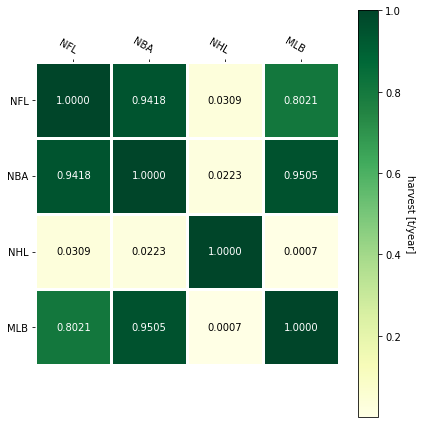

In [173]:
fig, ax = plt.subplots(figsize=(6,6))

im, cbar = heatmap(pval, names, names, ax=ax,
                   cmap="YlGn", cbarlabel="harvest [t/year]")
texts = annotate_heatmap(im, valfmt="{x:.4f}")

fig.tight_layout()
plt.show()

### Vemos aqui que, devido ao alto p-valor, na maioria dos casos não é possível descartar a hipótese nula, ou seja, regiões com times em diferentes ligas não significa que esses times terão performances parecidas.

In [213]:
pop_nfl, win_loss_nfl, corr_nfl, merged_nfl = corr_nfl(cities, nfl_df)
pop_nba, win_loss_nba, corr_nba, merged_nba = corr_nba(cities, nba_df)
pop_mlb, win_loss_mlb, corr_mlb, merged_mlb = corr_mlb(cities, mlb_df)
pop_nhl, win_loss_nhl, corr_nhl, merged_nhl = corr_nhl(cities, nhl_df)

In [214]:
(corr_nfl,
corr_nba,
corr_mlb,
corr_nhl)

(0.004922112149349409,
 -0.17657160252844614,
 0.15027698302669307,
 0.012486162921209923)

Text(12000000.0, 0.7, 'NHL, Corr = 0.012')

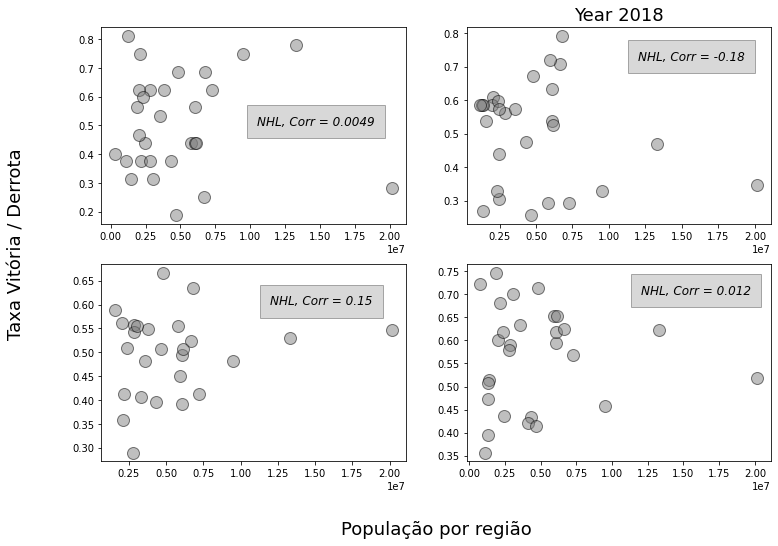

In [251]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(12,8))

ax[0][0].plot(pop_nfl,win_loss_nfl,'o',color='gray', markersize=12,markeredgecolor='k', alpha=0.5)
ax[0][0].set_ylabel(r'Taxa Vitória / Derrota', fontsize=18)
ax[0][0].yaxis.set_label_coords(-0.25, -0.1)
ax[0][0].text(1.05e7, 0.5, 'NHL, Corr = 0.0049', style='italic',
        bbox={'facecolor': 'gray', 'alpha': 0.3, 'pad': 10}, fontsize=12)

ax[0][1].plot(pop_nba, win_loss_nba,'o',color='gray', markersize=12,markeredgecolor='k', alpha=0.5)
ax[0][1].set_title(r'Year 2018',fontsize=18)
ax[0][1].text(1.2e7, 0.72, 'NHL, Corr = -0.18', style='italic',
        bbox={'facecolor': 'gray', 'alpha': 0.3, 'pad': 10}, fontsize=12)

ax[1][0].plot(pop_mlb, win_loss_mlb,'o',color='gray', markersize=12,markeredgecolor='k', alpha=0.5)
ax[1][0].text(1.2e7, 0.6, 'NHL, Corr = 0.15', style='italic',
        bbox={'facecolor': 'gray', 'alpha': 0.3, 'pad': 10}, fontsize=12)

ax[1][1].plot(pop_nhl, win_loss_nhl,'o',color='gray', markersize=12,markeredgecolor='k', alpha=0.5)
ax[1][1].set_xlabel(r'População por região', fontsize=18)
ax[1][1].xaxis.set_label_coords(-0.1, -0.3)
ax[1][1].text(1.2e7, 0.7, 'NHL, Corr = 0.012', style='italic',
        bbox={'facecolor': 'gray', 'alpha': 0.3, 'pad': 10}, fontsize=12)


## Podemos ver pela figura acima que não existem grandes correlações entre a taxa de vitórias dos times nas ligas e a população das regiões dos times.